# **EuroSAT Land Use and Land Cover Classification using Transfer Learning**

In this notebook, increasingly complex deep learning models are implementated to identify land use and land cover classifications on the [EuroSAT dataset](https://github.com/phelber/eurosat), a collection of 27,000 Sentinel-2 satellite images consisting of 13 spectral bands and 10 pre-labeled classes (e.g., Highway, AnnualCrop, River, Residential).

## **Part A. Data Preprocessing**

- Mount Google Drive and install the Python package Rasterio that can access to geospatial raster data 

- Download data from the Eurosat page: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

### **Step 1. Mount Google Drive and install the Python package Rasterio**

In [1]:
# Import Google Colab
import os
from google.colab import drive

In [2]:
# Set Direction
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/data/HW6')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Step 2. Import related packages for image processing and deep learning model**

In [3]:
!pip install rasterio
import os, torch, requests, zipfile, io, rasterio, tensorflow.keras
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, numpy as np, pandas as pd

from PIL import Image
from keras.datasets import cifar10
from rasterio.plot import show, show_hist
from skimage.color import rgb2gray
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import regularizers, initializers, optimizers, metrics, utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Add, AveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications import vgg19, resnet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#hyperparameters
batch_size=16
epochs=10


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Step 3. Download and read RGB EuroSAT images from URL**


In [4]:
# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [5]:
# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]


In [6]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  #Image.open() is an image opening function in the PIL module 'Image'
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255  #normalize image from [0, 255] to [0.0, 1.0]
  i += 1

print("The number of image: ", i)
print("The shape of XImages: ", XImages.shape) 
del r # clear memory
del z 

The number of image:  27000
The shape of XImages:  (27000, 64, 64, 3)


### **Step 4. Show the downloaded images**

[[[0.2        0.30196078 0.36078431]
  [0.21176471 0.29803922 0.35294118]
  [0.18823529 0.2627451  0.32156863]
  ...
  [0.34117647 0.36078431 0.38431373]
  [0.22745098 0.30980392 0.32941176]
  [0.17647059 0.30588235 0.3254902 ]]

 [[0.22352941 0.28627451 0.34509804]
  [0.22352941 0.29019608 0.35294118]
  [0.18039216 0.2627451  0.32941176]
  ...
  [0.31372549 0.37254902 0.4       ]
  [0.21568627 0.31372549 0.33333333]
  [0.18431373 0.30196078 0.33333333]]

 [[0.31372549 0.34901961 0.38431373]
  [0.30196078 0.34901961 0.39607843]
  [0.25098039 0.32156863 0.37647059]
  ...
  [0.22745098 0.3254902  0.34509804]
  [0.19215686 0.31372549 0.33333333]
  [0.19215686 0.30980392 0.34117647]]

 ...

 [[0.21568627 0.30588235 0.3372549 ]
  [0.22352941 0.30196078 0.32941176]
  [0.23529412 0.31764706 0.3372549 ]
  ...
  [0.29411765 0.35294118 0.36470588]
  [0.35294118 0.39607843 0.40392157]
  [0.3254902  0.36470588 0.36078431]]

 [[0.23921569 0.33333333 0.34901961]
  [0.23921569 0.33333333 0.34901961]


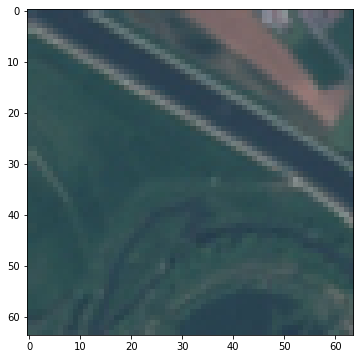

In [7]:
def plot_image(image):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    plt.show()

# Call plot_image() to display an image
print(XImages[0])
plot_image(XImages[0])


### **Step 5. Get image lables**

In [8]:
# Get labels in numpy array as strings
# Example: Extract "River" from "2750/River/River_479.jpg"
labs = np.empty(len(txtfiles), dtype='S20')
i = 0
for label in txtfiles:
  labs[i] = label.split('/')[1]
  i += 1

print(labs)
print(labs.shape)

#What does this b character in front of the string mean?
#Ans. Python 3.x makes a clear distinction between the types:
#-- str = '...'
#-- bytes = b'...'

[b'River' b'River' b'River' ... b'PermanentCrop' b'PermanentCrop'
 b'PermanentCrop']
(27000,)


In [9]:
# Change them to integers in alphabetical order

# unique()returns the sorted unique elements of an array;
# return_inverse: if true, return the indices of the unique array that can be used to reconstruct array
label_names, yLabels = np.unique(labs, return_inverse=True)

print("the shape of the label_names: ", label_names.shape)
print("label_names: ", label_names)
print()
print("the shape of the yLables: ", yLabels.shape)
print()

# create a dict: (yLabels, label_names)
label_Dict = dict(zip(np.unique(yLabels), label_names))
print("label_Dict: ", label_Dict)
print("\n")
np.array(np.unique(yLabels, return_counts=True)).T


the shape of the label_names:  (10,)
label_names:  [b'AnnualCrop' b'Forest' b'HerbaceousVegetation' b'Highway' b'Industrial'
 b'Pasture' b'PermanentCrop' b'Residential' b'River' b'SeaLake']

the shape of the yLables:  (27000,)

label_Dict:  {0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}




array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

### **Step 6. Show the processed images and labels**

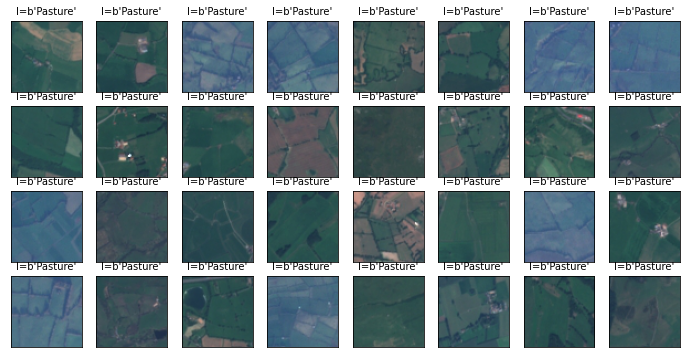

In [10]:
# Test that the labels and images read in properly
def plot_multiimages(images, labels, prediction, idx, num=32):
  fig, ax = plt.subplots(4, 8, figsize=(12, 6))
  if num > 32:
    num = 32  # if the number of images > 32，then set to 32 to avoid errors
  for i in range(0, num):
    ax = plt.subplot(4, 8, 1+i)  # Build 4x8 subgraphs
    ax.imshow(images[idx], cmap='binary')
    if len(prediction) > 0:
      title = "l={},p={}".format(str(label_names[labels[idx]]), str(prediction[idx]))
    else:
      title = "l={}".format(str(label_names[labels[idx]]))
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    idx += 1  # read the next image
  plt.show()

plot_multiimages(XImages, yLabels, [], 18000, 32)


### **Step 7. Shuffle the datasets and Balance the labels**

In [11]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
print("The class index of the smallest class: ",smallest_class, label_names[smallest_class])

The class index of the smallest class:  5 b'Pasture'


In [12]:
# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels==smallest_class)[0]

# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels==i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state=42)

yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)

(20000,)
(20000, 64, 64, 3)


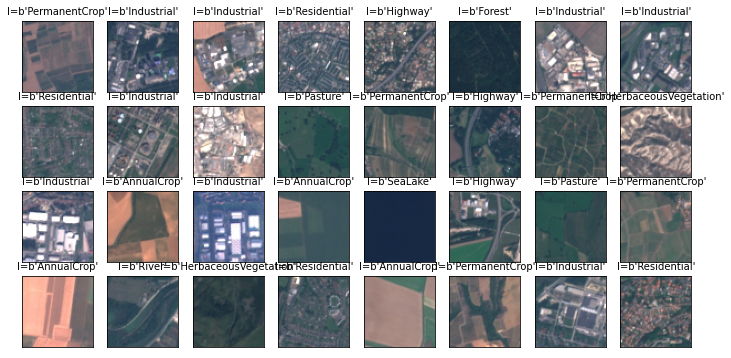

In [13]:
# first line uses balanced labels
# second line uses original imbalanced labels

# X_train, X_test, y_train, y_test=train_test_split(XBal, yBal, stratify=yBal, train_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify=yLabels, train_size=0.5, random_state=42)

# Test that the labels and images are still matched up properly
plot_multiimages(X_train, y_train, [], 300, 32)

In [14]:
# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

### **Part B. Model 1**

- Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

- Implement a first deep learning model `M1` using a fully connected network with a single dense layer. 

- **Classification accuracy on the test data.** 22.0%

This model does not include any spatial information (i.e., pixels don't have any information about neighboring pixels).

In [30]:
# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0], X_train_BW.shape[1]*X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0], X_test_BW.shape[1]*X_test_BW.shape[2])

In [31]:
print("X_train_BW shape: " + str(X_train_BW.shape))
print("X_test_BW shape: " + str(X_test_BW.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train_BW shape: (13500, 4096)
X_test_BW shape: (13500, 4096)
y_train shape: (13500, 10)
y_test shape: (13500, 10)


Implement first deep learning model

In [32]:
M1 = Sequential()
M1.add(Dense(num_classes, activation='softmax', input_shape=(4096,)))
M1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                40970     
                                                                 
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [33]:
M1.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
train_history_M1=M1.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 [==============================] - 4s 4ms/step - loss: 2.4467 - accuracy: 0.1417 - val_loss: 2.2294 - val_accuracy: 0.1459
Epoch 2/10
844/844 [==============================] - 3s 4ms/step - loss: 2.3709 - accuracy: 0.1703 - val_loss: 2.3497 - val_accuracy: 0.1604
Epoch 3/10
844/844 [==============================] - 3s 4ms/step - loss: 2.3379 - accuracy: 0.1910 - val_loss: 2.2820 - val_accuracy: 0.1716
Epoch 4/10
844/844 [==============================] - 3s 4ms/step - loss: 2.2868 - accuracy: 0.2116 - val_loss: 2.1615 - val_accuracy: 0.1902
Epoch 5/10
844/844 [==============================] - 3s 4ms/step - loss: 2.2587 - accuracy: 0.2214 - val_loss: 2.3317 - val_accuracy: 0.1833
Epoch 6/10
844/844 [==============================] - 3s 4ms/step - loss: 2.2204 - accuracy: 0.2374 - val_loss: 2.5721 - val_accuracy: 0.1590
Epoch 7/10
844/844 [==============================] - 3s 4ms/step - loss: 2.1915 - accuracy: 0.2444 - val_loss: 2.2283 - val_accuracy: 0.2151
Epoch 

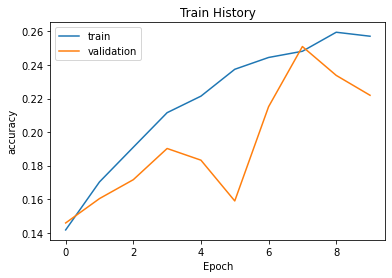

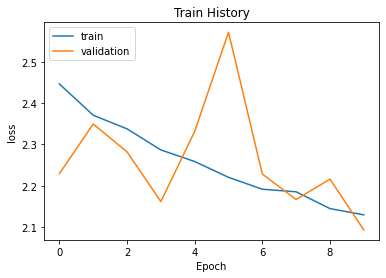

In [34]:
# Show Train History
def show_train_history(train_history, train, validation, filename):  
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')  
    plt.xlabel('Epoch') 
    plt.ylabel(train)  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.savefig(filename)
    plt.show()

show_train_history(train_history_M1,'accuracy','val_accuracy', './picture/train_history1_accuracy.png')
show_train_history(train_history_M1,'loss','val_loss', './picture/train_history1_loss.png')

In [35]:
# Save Model
M1.save('./model1.h5') 

In [36]:
# Load Model
M1 = load_model('./model1.h5')

In [37]:
# Score
scores = M1.evaluate(X_test_BW, y_test)
print()
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
print("\t[Info]   Loss   of testing data = {:0.4f}".format(scores[0]))

422/422 [==============================] - 1s 2ms/step - loss: 2.0928 - accuracy: 0.2219

	[Info] Accuracy of testing data = 22.2%
	[Info]   Loss   of testing data = 2.0928


### **Part B. Model 2**

- Using RGB images (without vectorizing them), implement a fourth model `M2` that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

- **Classification accuracy on the test data.** 76.2%

In [38]:
input_shape = X_train.shape[1:]

In [39]:
M2 = Sequential()
M2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
M2.add(Conv2D(64, (3, 3), activation='relu'))
M2.add(MaxPooling2D(pool_size=(2, 2)))
M2.add(Dropout(0.2))
M2.add(Flatten())
M2.add(Dense(256, activation='relu'))
M2.add(Dropout(0.2))
M2.add(Dense(num_classes, activation='softmax'))

M2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               14745856  
                                                      

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13500, 64, 64, 3)
(13500, 10)
(13500, 64, 64, 3)
(13500, 10)


In [41]:
M2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
train_history_M2 = M2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
844/844 [==============================] - 12s 13ms/step - loss: 1.3159 - accuracy: 0.5119 - val_loss: 0.9196 - val_accuracy: 0.6667
Epoch 2/10
844/844 [==============================] - 11s 13ms/step - loss: 0.7718 - accuracy: 0.7255 - val_loss: 0.7292 - val_accuracy: 0.7401
Epoch 3/10
844/844 [==============================] - 11s 13ms/step - loss: 0.5806 - accuracy: 0.7909 - val_loss: 0.6503 - val_accuracy: 0.7707
Epoch 4/10
844/844 [==============================] - 11s 13ms/step - loss: 0.4377 - accuracy: 0.8466 - val_loss: 0.6009 - val_accuracy: 0.7997
Epoch 5/10
844/844 [==============================] - 11s 13ms/step - loss: 0.3518 - accuracy: 0.8784 - val_loss: 0.7466 - val_accuracy: 0.7668
Epoch 6/10
844/844 [==============================] - 11s 13ms/step - loss: 0.2736 - accuracy: 0.9057 - val_loss: 0.6969 - val_accuracy: 0.7850
Epoch 7/10
844/844 [==============================] - 11s 13ms/step - loss: 0.2044 - accuracy: 0.9306 - val_loss: 0.7842 - val_accuracy:

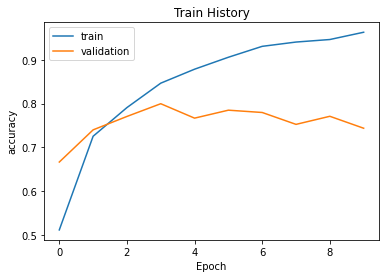

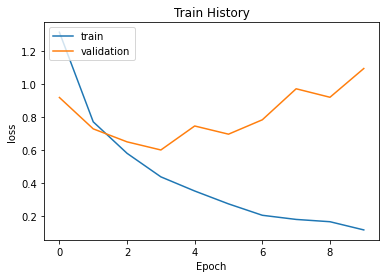

In [42]:
# Show Train History
def show_train_history(train_history, train, validation, filename):  
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')  
    plt.xlabel('Epoch') 
    plt.ylabel(train)  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.savefig(filename)
    plt.show()

show_train_history(train_history_M2,'accuracy','val_accuracy', './picture/train_history2_accuracy.png')
show_train_history(train_history_M2,'loss','val_loss', './picture/train_history2_loss.png')

In [43]:
# Save Model
M2.save('./model2.h5') 

In [44]:
# Load Model
M2 = load_model('./model2.h5')

Interestingly, testing loss deterioates rapidly rapidly after about 10 epochs, but testing accuracy deteriorates more slowly.

In [45]:
# Score
scores = M2.evaluate(X_test, y_test)
print()
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
print("\t[Info]   Loss   of testing data = {:0.4f}".format(scores[0]))

422/422 [==============================] - 3s 6ms/step - loss: 1.0956 - accuracy: 0.7438

	[Info] Accuracy of testing data = 74.4%
	[Info]   Loss   of testing data = 1.0956


### **Part C. Transfer Learning Assignment: Use a pretrained model as a base model**

Hint:
1. Use the Keras avaliable models
2. Use data augmentation for overfitting problem
3. Use adative learning rate

**Transfer Learning Base in VGG19**

In [15]:
# Load VGG19 Model
input_shape = X_train.shape[1:]
model_VGG19 = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Create My Model Base in VGG19
model_transfer_VGG19 = Sequential()
model_transfer_VGG19.add(model_VGG19)

model_transfer_VGG19.add(Dense(2048, activation='relu'))
model_transfer_VGG19.add(Dropout(0.5))
model_transfer_VGG19.add(Dense(512, activation='relu'))
model_transfer_VGG19.add(Dropout(0.5))
model_transfer_VGG19.add(Flatten())
model_transfer_VGG19.add(Dense(10, activation='softmax'))

# Summary
model_transfer_VGG19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 dense (Dense)               (None, 2, 2, 2048)        1050624   
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 dense_1 (Dense)             (None, 2, 2, 512)         1049088   
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [16]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)    

In [17]:
# Train Model
model_transfer_VGG19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
img_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, horizontal_flip=True, zoom_range=0.1)
img_gen.fit(X_train)

train_history_transfer_VGG19 = model_transfer_VGG19.fit(img_gen.flow(X_train, y_train, batch_size=32), epochs=50, callbacks=[callback], shuffle=True, validation_data = (X_test, y_test), verbose=1)

Epoch 1/50
422/422 [==============================] - 48s 90ms/step - loss: 1.8223 - accuracy: 0.2784 - val_loss: 1.3351 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 2/50
422/422 [==============================] - 35s 84ms/step - loss: 1.6953 - accuracy: 0.3600 - val_loss: 2.1617 - val_accuracy: 0.1861 - lr: 0.0010
Epoch 3/50
422/422 [==============================] - 35s 83ms/step - loss: 1.4417 - accuracy: 0.4211 - val_loss: 1.3316 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 4/50
422/422 [==============================] - 35s 83ms/step - loss: 1.3761 - accuracy: 0.4641 - val_loss: 1.2854 - val_accuracy: 0.5016 - lr: 0.0010
Epoch 5/50
422/422 [==============================] - 35s 84ms/step - loss: 1.2406 - accuracy: 0.5301 - val_loss: 1.2656 - val_accuracy: 0.5112 - lr: 0.0010
Epoch 6/50
422/422 [==============================] - 35s 84ms/step - loss: 1.1606 - accuracy: 0.5725 - val_loss: 1.0140 - val_accuracy: 0.6038 - lr: 0.0010
Epoch 7/50
422/422 [==============================] - 35s 

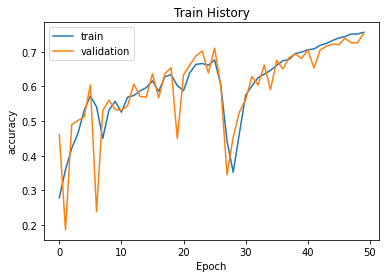

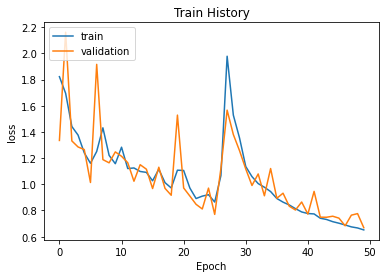

In [18]:
# Show Train History
def show_train_history(train_history, train, validation, filename):  
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')  
    plt.xlabel('Epoch') 
    plt.ylabel(train)  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.savefig(filename)
    plt.show()

show_train_history(train_history_transfer_VGG19, 'accuracy', 'val_accuracy', './picture/train_history_accuracy_transfer_VGG19.png')
show_train_history(train_history_transfer_VGG19, 'loss', 'val_loss', './picture/train_history_loss_transfer_VGG19.png')

In [19]:
# Save Model
model_transfer_VGG19.save('./model_transfer_VGG19.h5') 

In [20]:
# Load Model
model_transfer_VGG19 = load_model('./model_transfer_VGG19.h5')

In [21]:
# Score
scores = model_transfer_VGG19.evaluate(X_test, y_test)
print()
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
print("\t[Info]   Loss   of testing data = {:0.4f}".format(scores[0]))

422/422 [==============================] - 9s 21ms/step - loss: 0.6685 - accuracy: 0.7527

	[Info] Accuracy of testing data = 75.3%
	[Info]   Loss   of testing data = 0.6685


**Transfer Learning Base in ResNet50**

In [22]:
# Load ResNet50 Model
input_shape = X_train.shape[1:]
model_ResNet50 = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Create My Model Base in ResNet50
model_transfer_ResNet50 = Sequential()

model_transfer_ResNet50.add(model_ResNet50)
model_transfer_ResNet50.add(Flatten())
model_transfer_ResNet50.add(Dense(10, activation='softmax'))

# Summary
model_transfer_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                81930     
                                                                 
Total params: 23,669,642
Trainable params: 23,616,522
Non-trainable params: 53,120
_________________________________________________________________


In [23]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)  

In [25]:
# Train Model
model_transfer_ResNet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
img_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, horizontal_flip=True, zoom_range=0.1)
img_gen.fit(X_train)

train_history_transfer_ResNet50 = model_transfer_ResNet50.fit(img_gen.flow(X_train, y_train, batch_size=32), epochs=50, callbacks=[callback], shuffle=True, validation_data = (X_test, y_test), verbose=1)

Epoch 1/50
422/422 [==============================] - 36s 71ms/step - loss: 0.3493 - accuracy: 0.9018 - val_loss: 1.9681 - val_accuracy: 0.7777 - lr: 0.0010
Epoch 2/50
422/422 [==============================] - 30s 70ms/step - loss: 0.2533 - accuracy: 0.9319 - val_loss: 0.6916 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 3/50
422/422 [==============================] - 29s 69ms/step - loss: 0.2372 - accuracy: 0.9356 - val_loss: 0.8304 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 4/50
422/422 [==============================] - 29s 69ms/step - loss: 0.2417 - accuracy: 0.9382 - val_loss: 1.2526 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 5/50
422/422 [==============================] - 29s 70ms/step - loss: 1.0110 - accuracy: 0.7665 - val_loss: 9.5136 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 6/50
422/422 [==============================] - 29s 69ms/step - loss: 1.1968 - accuracy: 0.6963 - val_loss: 0.8931 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 7/50
422/422 [==============================] - 29s 

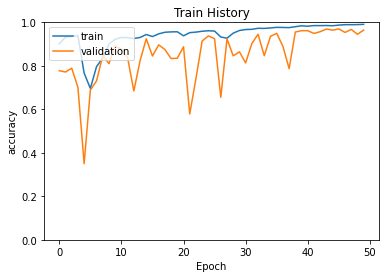

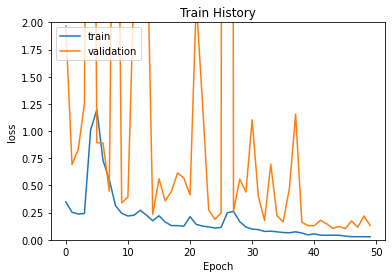

In [49]:
# Show Train History
def show_train_history(train_history, train, validation, filename, y1, y2):  
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')  
    plt.xlabel('Epoch') 
    plt.ylabel(train)
    plt.ylim(y1, y2)  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.savefig(filename)
    plt.show()

show_train_history(train_history_transfer_ResNet50, 'accuracy', 'val_accuracy', './picture/train_history_accuracy_transfer_ResNet50.png', 0, 1)
show_train_history(train_history_transfer_ResNet50, 'loss', 'val_loss', './picture/train_history_loss_transfer_ResNet50.png', 0, 2)

In [27]:
# Save Model
model_transfer_ResNet50.save('./model_transfer_ResNet50.h5') 

In [28]:
# Load Model
model_transfer_ResNet50 = load_model('./model_transfer_ResNet50.h5')

In [46]:
# Score
scores = model_transfer_ResNet50.evaluate(X_test, y_test)
print()
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
print("\t[Info]   Loss   of testing data = {:0.4f}".format(scores[0]))

422/422 [==============================] - 8s 16ms/step - loss: 0.1321 - accuracy: 0.9647

	[Info] Accuracy of testing data = 96.5%
	[Info]   Loss   of testing data = 0.1321
